In [1]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [2]:
TRAIN_DIR = "./deepglobe-land-cover-classification-dataset/train"
COLOR_CODES = "./deepglobe-land-cover-classification-dataset/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

df = pd.read_csv(COLOR_CODES)
label_map = {}

for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]

In [3]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg') and not filename.startswith("._")])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png') and not filename.startswith("._")])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return {"image": image, "mask": mask}
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.int64)

In [4]:

big_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(big_dataset,[0.75,0.15,0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [5]:
class ModelCreate(L.LightningModule):

    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes):
        super().__init__()

        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=encoder_weights)

        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        params = smp.encoders.get_preprocessing_params(encoder_name, encoder_weights)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4

        assert mask.max() <= 7 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), prob_mask.long(), num_classes=7, mode="multiclass")

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [6]:
model = ModelCreate("Linknet", "resnet50", 'imagenet', in_channels=3, out_classes=7)

In [7]:
earlystop_callback = EarlyStopping('valid_loss', patience=3)

# Windows w/ CUDA
# trainer = L.Trainer(max_epochs=15, logger=CSVLogger(save_dir="logs/", name="unetpp"), callbacks=[earlystop_callback])

# Apple Silicon
trainer = L.Trainer(accelerator="mps" ,max_epochs=15, logger=CSVLogger(save_dir="logs/", name="unetpp"), callbacks=[earlystop_callback])

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/unetpp

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 49.0 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: 100%|██████████| 151/151 [13:17<00:00,  0.19it/s, v_num=18, valid_loss=0.409, valid_per_image_iou=0.739, valid_dataset_iou=0.739, train_loss=0.420, train_per_image_iou=0.740, train_dataset_iou=0.740]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 151/151 [13:22<00:00,  0.19it/s, v_num=18, valid_loss=0.409, valid_per_image_iou=0.739, valid_dataset_iou=0.739, train_loss=0.420, train_per_image_iou=0.740, train_dataset_iou=0.740]


In [32]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 30/30 [02:07<00:00,  0.24it/s]
[{'valid_loss': 0.40648576617240906, 'valid_per_image_iou': 0.7390283346176147, 'valid_dataset_iou': 0.7389987707138062}]


In [33]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 20/20 [01:30<00:00,  0.22it/s]
[{'test_loss': 0.4142783582210541, 'test_per_image_iou': 0.7439695596694946, 'test_dataset_iou': 0.7439602017402649}]


,step,test_dataset_iou,test_loss,test_per_image_iou,train_dataset_iou,train_loss,train_per_image_iou,valid_dataset_iou,valid_loss,valid_per_image_iou
epoch,,,,,,,,,,
0,150.0,NaN,NaN,NaN,0.546911,0.650972,0.548226,0.546911,0.567011,0.548226
1,301.0,NaN,NaN,NaN,0.689602,0.596024,0.692363,0.689602,0.513246,0.692363
2,452.0,NaN,NaN,NaN,0.691867,0.560807,0.693777,0.691867,0.488743,0.693777
3,603.0,NaN,NaN,NaN,0.710361,0.536149,0.711130,0.710361,0.471704,0.711130
4,754.0,NaN,NaN,NaN,0.732693,0.514693,0.732723,0.732693,0.464565,0.732723
5,905.0,NaN,NaN,NaN,0.736208,0.497144,0.736258,0.736208,0.451785,0.736258
6,1056.0,NaN,NaN,NaN,0.734794,0.483680,0.734848,0.734794,0.440269,0.734848
7,1207.0,NaN,NaN,NaN,0.729383,0.471309,0.729460,0.729383,0.433568,0.729460
8,1358.0,NaN,NaN,NaN,0.737325,0.460911,0.737354,0.737325,0.428455,0.737354


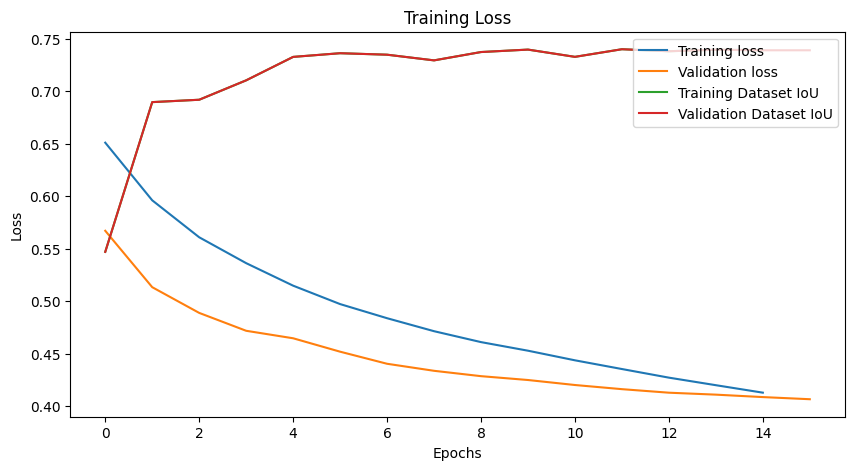

In [34]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')